In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import data_actions.data_processing.utils as utils

# Data exploration for RecSys 2025

For the purpose of the efficiency and processing multiple datasets with millions of rows, we decided to use **Polars** instead of Pandas, because of its Lazy API, which enables us to better manage memory.


In [2]:
data_folder = "data/original_data"
data = utils.load_data(data_folder)


The timestamp column should be converted from string to datetime, as Polars is unable to convert it automatically while loading.

In [3]:
for key in data["events"]:
    data["events"][key] = utils.convert_timestamp_to_datetime(data["events"][key])
    


c:\Users\adams\VSC projects\RecSys2025\data_actions\data_processing\utils.py:64: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  if "timestamp" in df.columns:


At first, we want to examine general features of our dataset. Let's check out all the tables. We can see that dates range from 23rd May to 10th December of 2022. 

In the dataset, there are about:
- 1.7 million boughts
- 5.2 millions addings to cart
- 1.7 million removals from cart
- 150 millions page visits
- 9.6 millions search queries

In [6]:
for df in data["events"]:
    print(f"{df}:")
    print(data["events"][df].describe())

add_to_cart:
shape: (9, 4)
┌────────────┬─────────────┬────────────────────────────┬───────────────┐
│ statistic  ┆ client_id   ┆ timestamp                  ┆ sku           │
│ ---        ┆ ---         ┆ ---                        ┆ ---           │
│ str        ┆ f64         ┆ str                        ┆ f64           │
╞════════════╪═════════════╪════════════════════════════╪═══════════════╡
│ count      ┆ 5.235882e6  ┆ 5235882                    ┆ 5.235882e6    │
│ null_count ┆ 0.0         ┆ 0                          ┆ 0.0           │
│ mean       ┆ 1.1941e7    ┆ 2022-08-06 03:13:35.597350 ┆ 748255.043147 │
│ std        ┆ 6.8914e6    ┆ null                       ┆ 433663.464805 │
│ min        ┆ 5.0         ┆ 2022-05-23 00:10:15        ┆ 0.0           │
│ 25%        ┆ 5.964675e6  ┆ 2022-07-01 19:22:20        ┆ 370909.0      │
│ 50%        ┆ 1.194213e7  ┆ 2022-08-08 22:15:45        ┆ 748335.0      │
│ 75%        ┆ 1.790411e7  ┆ 2022-09-12 10:08:30        ┆ 1.12609e6     │
│ max      

There is over 18 million users in the dataset.

In [7]:
clients = pl.concat([data["events"][df].select("client_id") for df in data["events"] if df != "product_properties"])
unique_clients = clients.select(pl.col("client_id").n_unique()).collect().item()
print(f"Unique clients: {unique_clients}")

Unique clients: 18889063


In [ ]:
def normalize_by_days_number(grouped_df, dataframe):
    days_df = (
        dataframe.with_columns(
            month=pl.col("timestamp").dt.month()
        )
        .group_by("month")
        .agg([
            pl.col("timestamp").dt.day().min().alias("min_day"),
            pl.col("timestamp").dt.day().max().alias("max_day")
        ])
        .with_columns(
            days = (pl.col("max_day") - pl.col("min_day") + 1)
        )
    )
    grouped_df = grouped_df.with_columns(
        month=pl.col("timestamp").dt.month()
    )
    grouped_df = (
        grouped_df.join(days_df, on="month", how="left")
                  .with_columns(
                      len = pl.col("len") / pl.col("days")
                  )
                  .drop(["month", "min_day", "max_day", "days"])
    )
    return grouped_df

def plot_histograms(normalize=True):
    fig, ax = plt.subplots(3, 2, figsize=(20, 12))
    fig.suptitle("Number of events per day for every table" if normalize else "Number of events per month for every table")

    for i, key in enumerate(data["events"]):
        dataframe = data["events"][key].sort("timestamp")
        grouped_df = dataframe.group_by_dynamic("timestamp", every="1mo").agg(pl.len().alias("len"))
        
        if normalize:
            grouped_df = normalize_by_days_number(grouped_df, dataframe)
        
        grouped_df = grouped_df.collect()
        
        ax[i//2][i % 2].bar(grouped_df["timestamp"], grouped_df["len"], width=20, align="center")
        ax[i//2][i % 2].set_title(key)
        ax[i//2][i % 2].set_xlabel("Date")
        ax[i//2][i % 2].set_ylabel("Number of events")
    
    fig.tight_layout()
    plt.show()

Fortunately, there isn't much disproportion in the number of events per day between each month, but slight increase tendention should be noticed. When we look at numbers per month, much less value can be seen in May and October - that's because the dataset date range started at May 23rd and ended at October 10th.

What's interesting, page visits number per day don't increase through the time, which indicates that people view the same number of items, but buy more of them.

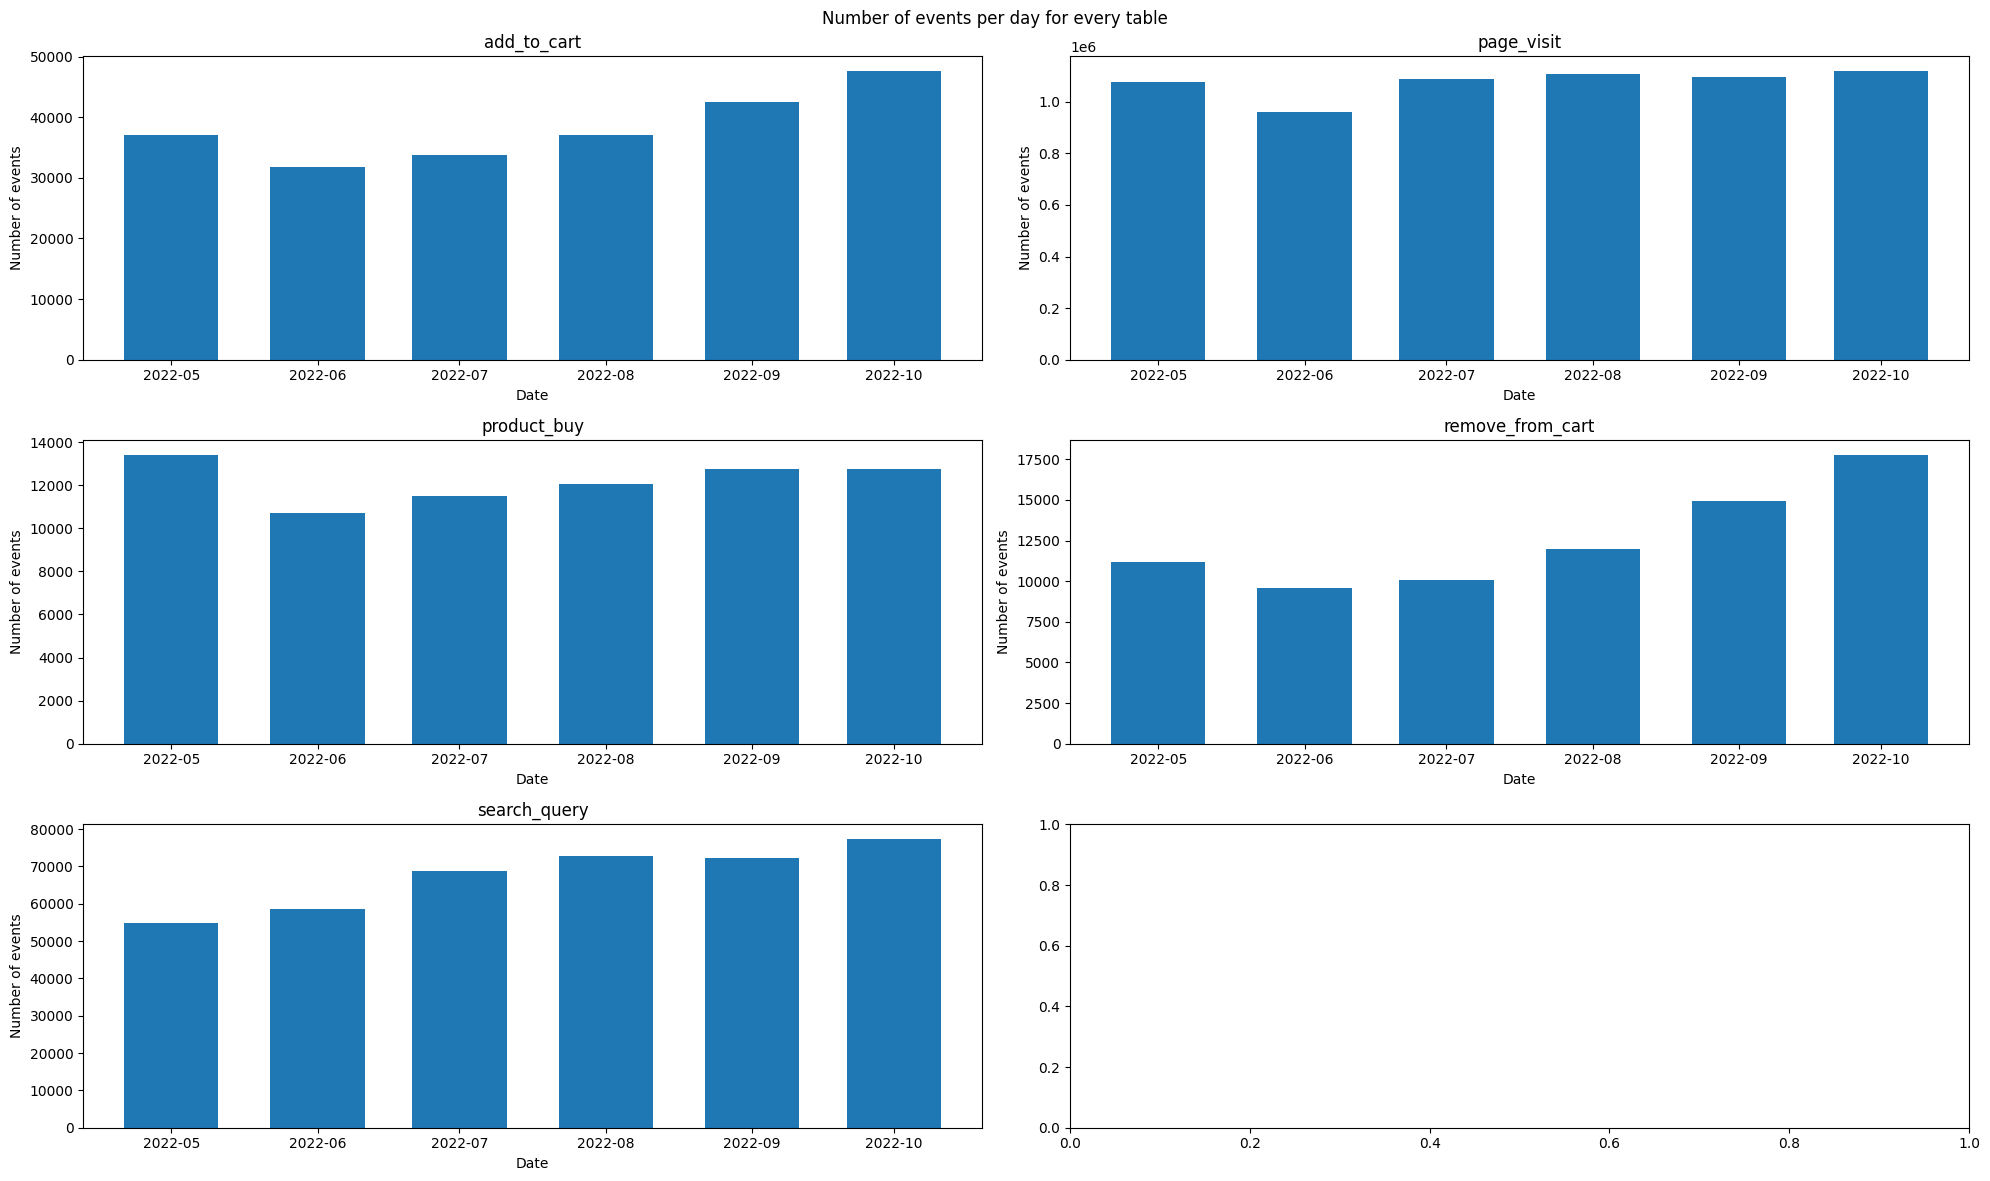

In [ ]:
plot_histograms(normalize=False)

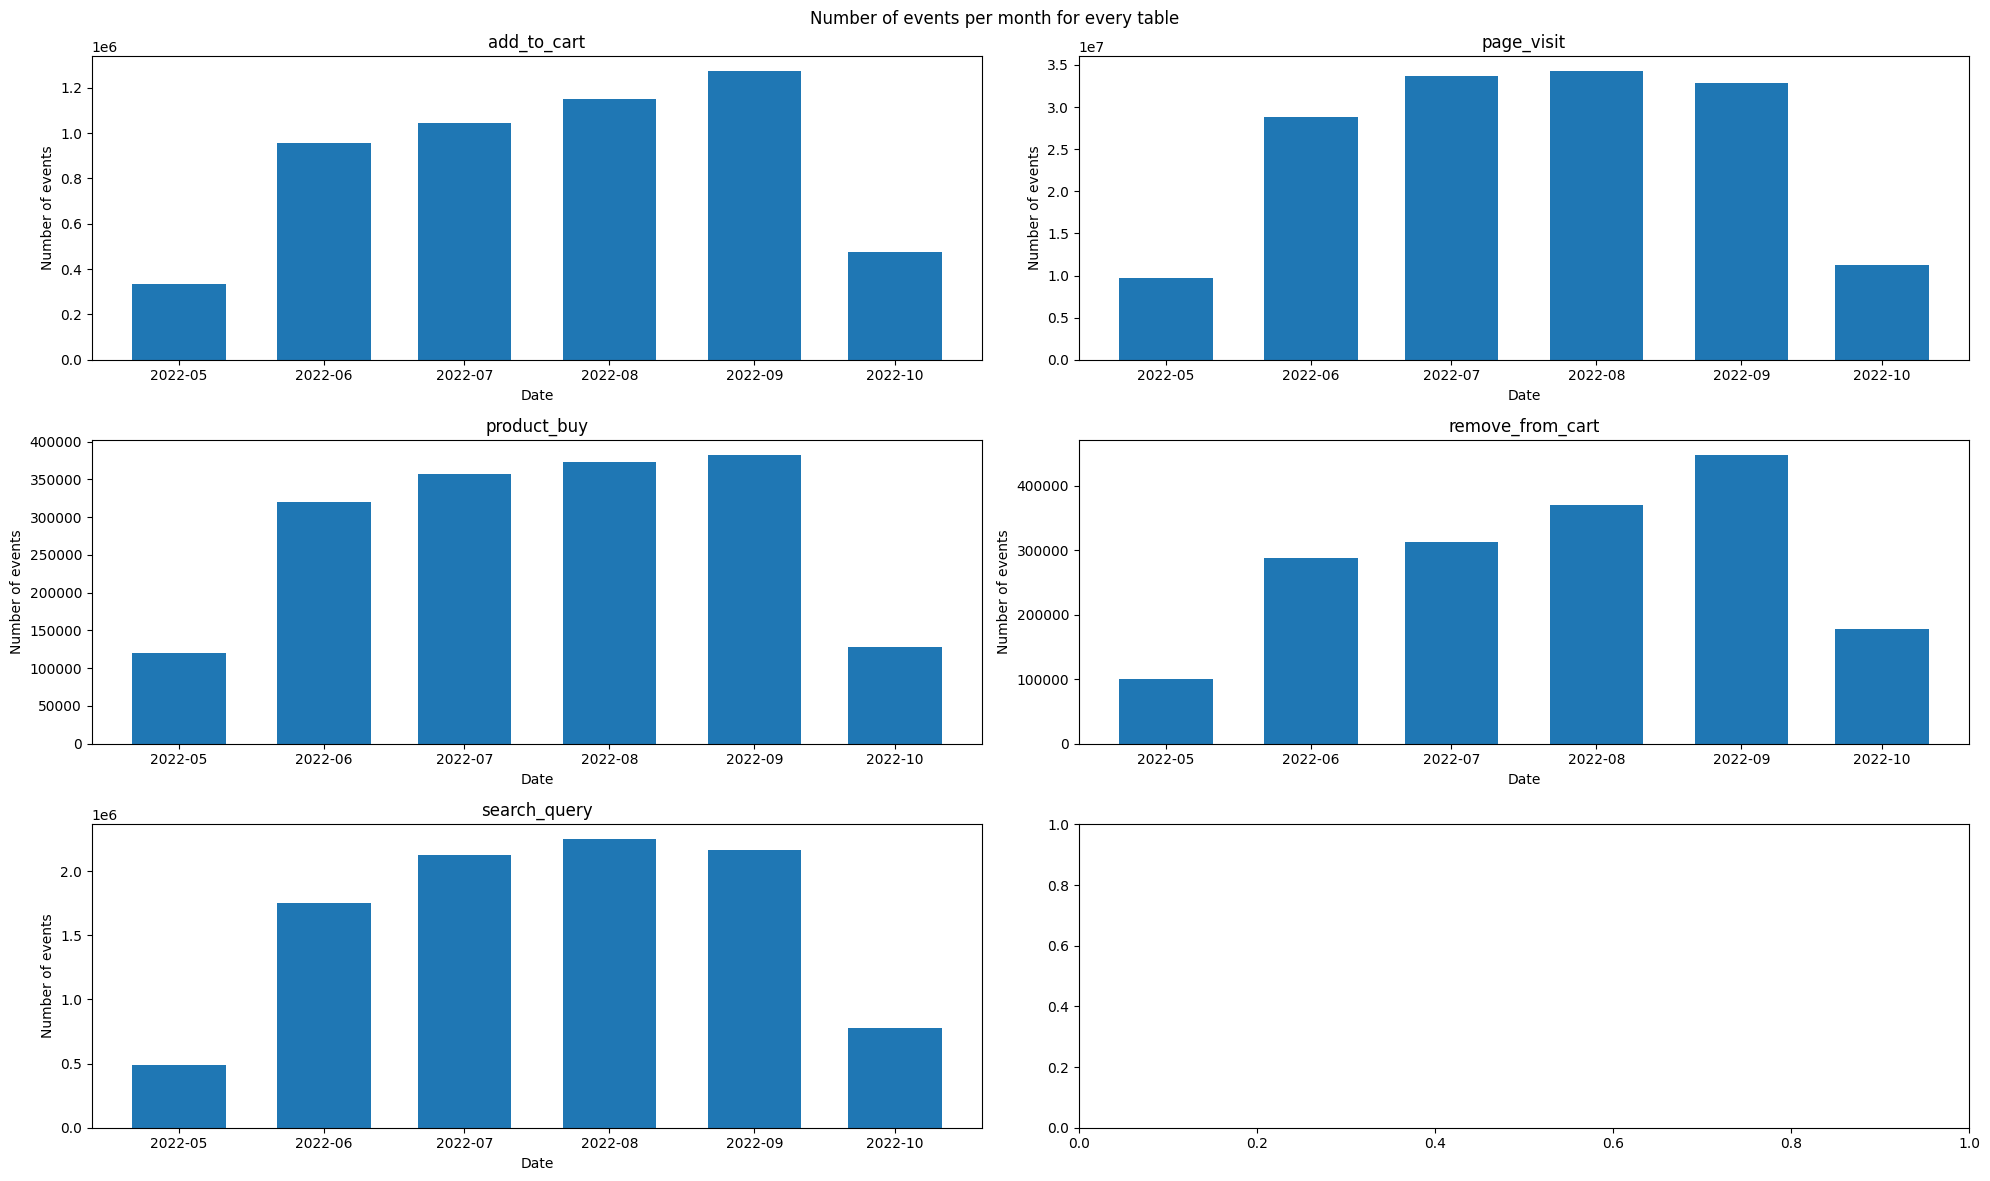

In [ ]:
plot_histograms(normalize=True)

In [ ]:
def plot_users_events_histogram():
    fig, ax = plt.subplots(3, 2, figsize=(20, 12))
    fig.suptitle("Number of events per client for every table")
    
    for i, key in enumerate(data["events"]):

        dataframe = data["events"][key].group_by("client_id").agg(pl.len().alias("count")).collect()
        ax[i//2][i % 2].hist(dataframe["count"], bins=20)
        ax[i//2][i % 2].set_title(key)
        ax[i//2][i % 2].set_xlabel("Date")
        ax[i//2][i % 2].set_ylabel("Number of events")
        ax[i//2][i % 2].set_yscale('log')
    
    fig.tight_layout()
    plt.show()

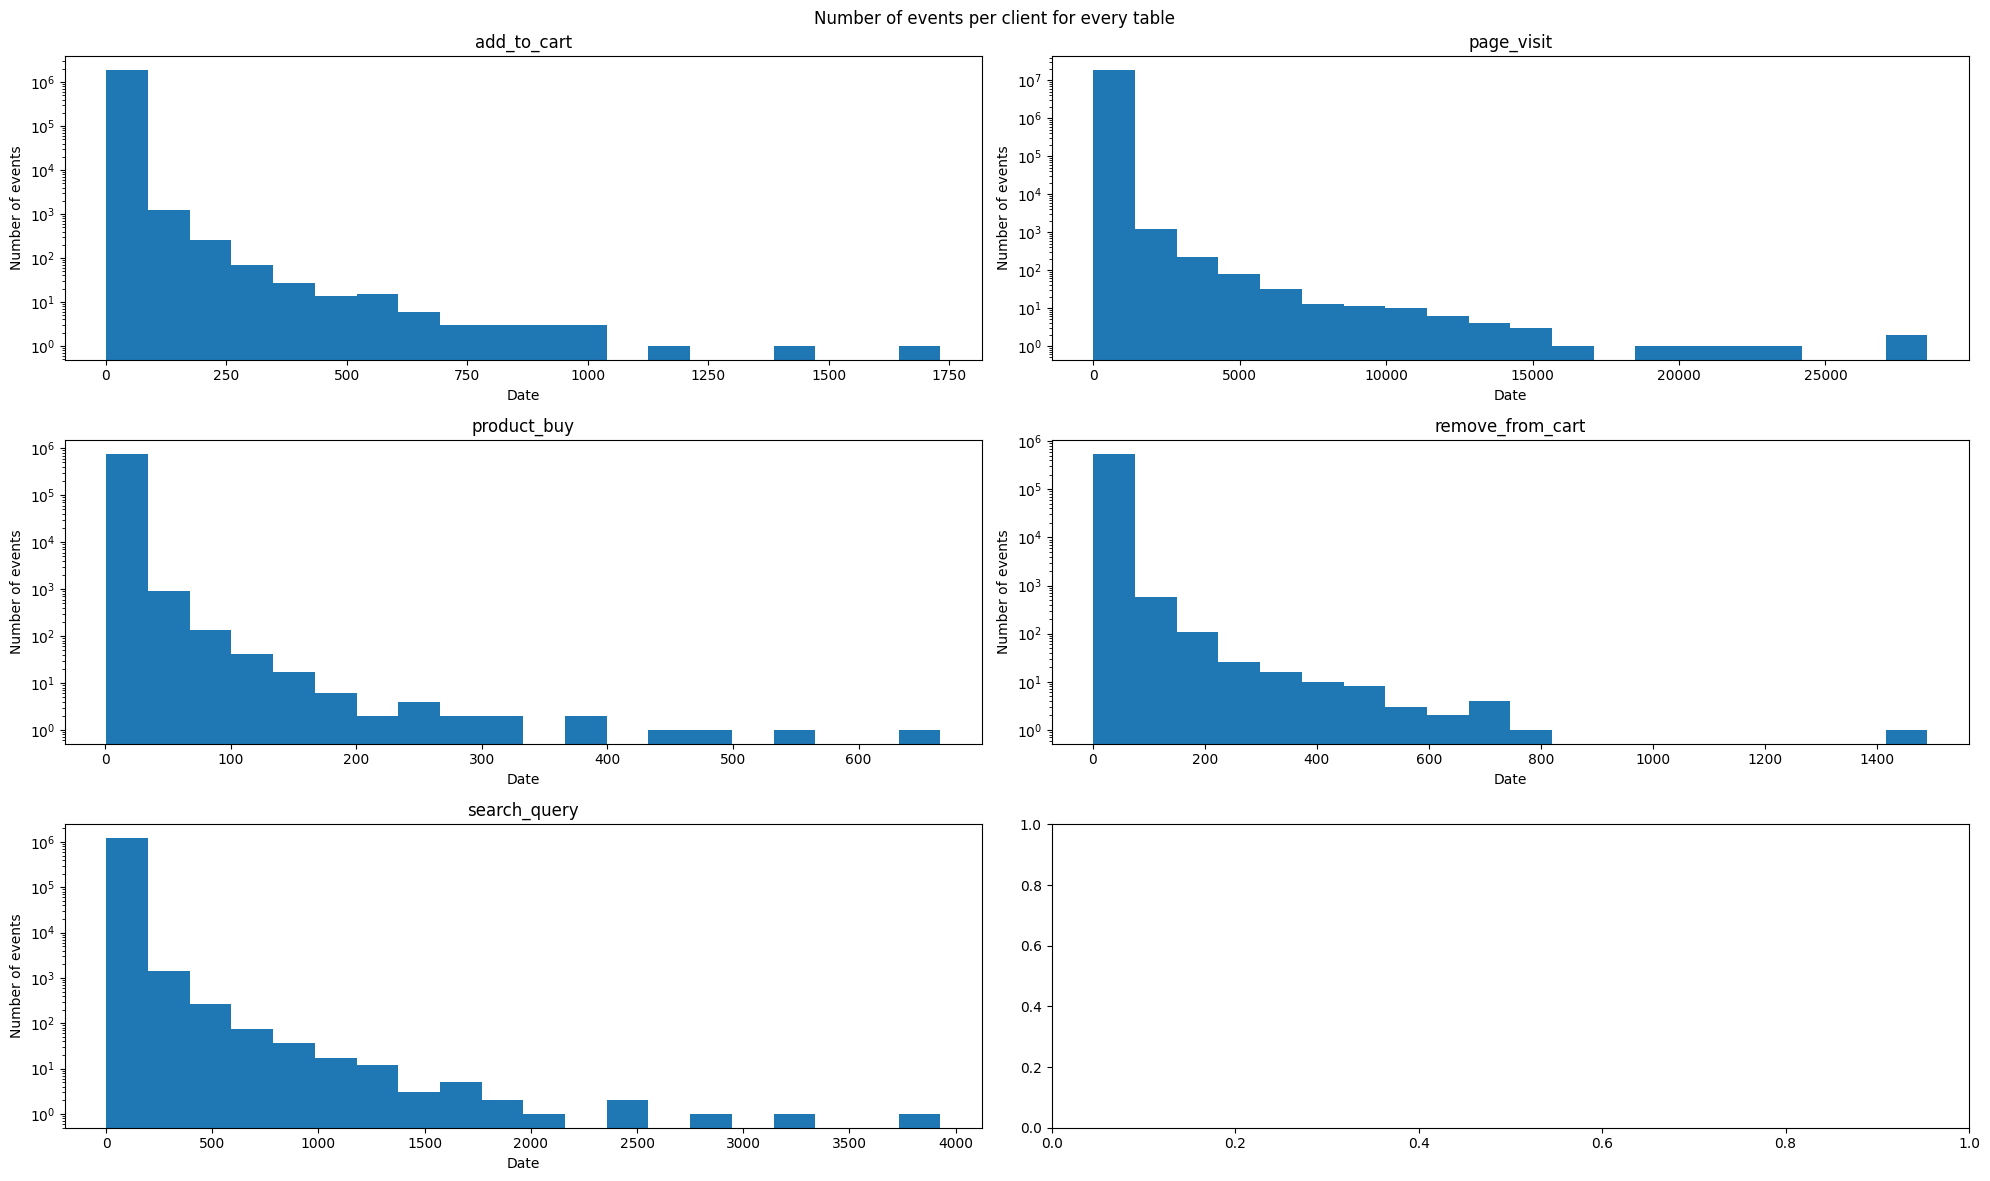

In [19]:
plot_users_events_histogram()